
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Extended Data Figure 8
-----

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

In [3]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

In [4]:
sys.path.append(str(root_dir))
import helper_functions.ml_utils as mu

/Users/mehdi/Documents/py_envs/ms_codes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.tsv'), sep='\t', index_col=0)
low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

In [6]:
kzm_types = pd.concat([kzm611_md[kzm611_md.Cohort=='KiCS'].Type.value_counts(),
                       kzm611_md[kzm611_md.Cohort=='ZCC'].Type.value_counts(),
                       kzm611_md[kzm611_md.Cohort=='MSK'].Type.value_counts()], axis=1)
kzm_types.columns = ['KiCS', 'ZCC', 'MSK']
kzm_types = kzm_types.fillna(0).astype(int)
kzm_types['Total'] = kzm_types.sum(axis=1)

kzm_types_sorted = kzm_types.sort_values(['Total'], ascending=False)
#kzm_types_sorted = kzm_types_sorted.drop(['Total'], axis=1)

kzm_types_sorted.head(10)

,KiCS,ZCC,MSK,Total
Type,,,,
NBL,48,23,17,88
HGG,23,30,1,54
OST,19,10,15,44
BALL,21,13,0,34
EWS,10,18,2,30
ERMS,15,6,5,26
DMG,4,22,0,26
ARMS,9,11,1,21
WT,12,4,2,18


In [7]:
pog570_md = pd.read_csv(os.path.join(root_dir, 'source_data/POG_data/POG_patients.tsv'), sep='\t', index_col=0)
pog570_md.head(2)

,SAMPLE_ID_DNA,SAMPLE_ID_RNA,AGE,GENDER,TUMOUR_TYPE,HISTOLOGICAL_TYPE,BIOPSY_SITE,BIOPSY_COHORT,ANALYSIS_COHORT,PRIMARY_SITE,METASTATIC_OR_RECURRENCE,TUMOUR_CONTENT,EGAD_ID
PATIENT_ID,,,,,,,,,,,,,
11004,A10504,A10506,30,F,Colorectal Adenocarcinoma,COAD,Liver,Liver,COLO,Colon,Metastatic,73,EGAD00001001307
11307,A10512,A10513,48,F,Breast Invasive Ductal Carcinoma,IDC,Liver,Liver,BRCA,Breast,Metastatic,59,EGAD00001002017


In [8]:
pog_types = pd.DataFrame(pog570_md.HISTOLOGICAL_TYPE.value_counts())

In [9]:
'''kzm_colors = ['red' if x in pog570_md.HISTOLOGICAL_TYPE.unique().tolist() else 'black' for x in kzm611_md.Type.unique()]
pog_colors = ['red' if x in kzm611_md.Type.unique().tolist() else 'black' for x in pog570_md.HISTOLOGICAL_TYPE.unique()]'''

kzm_colors = {x: 'red' if x in pog570_md.HISTOLOGICAL_TYPE.unique().tolist() else 'black' for x in kzm611_md.Type.unique()}
pog_colors = {x: 'red' if x in kzm611_md.Type.unique().tolist() else 'black' for x in pog570_md.HISTOLOGICAL_TYPE.unique()}

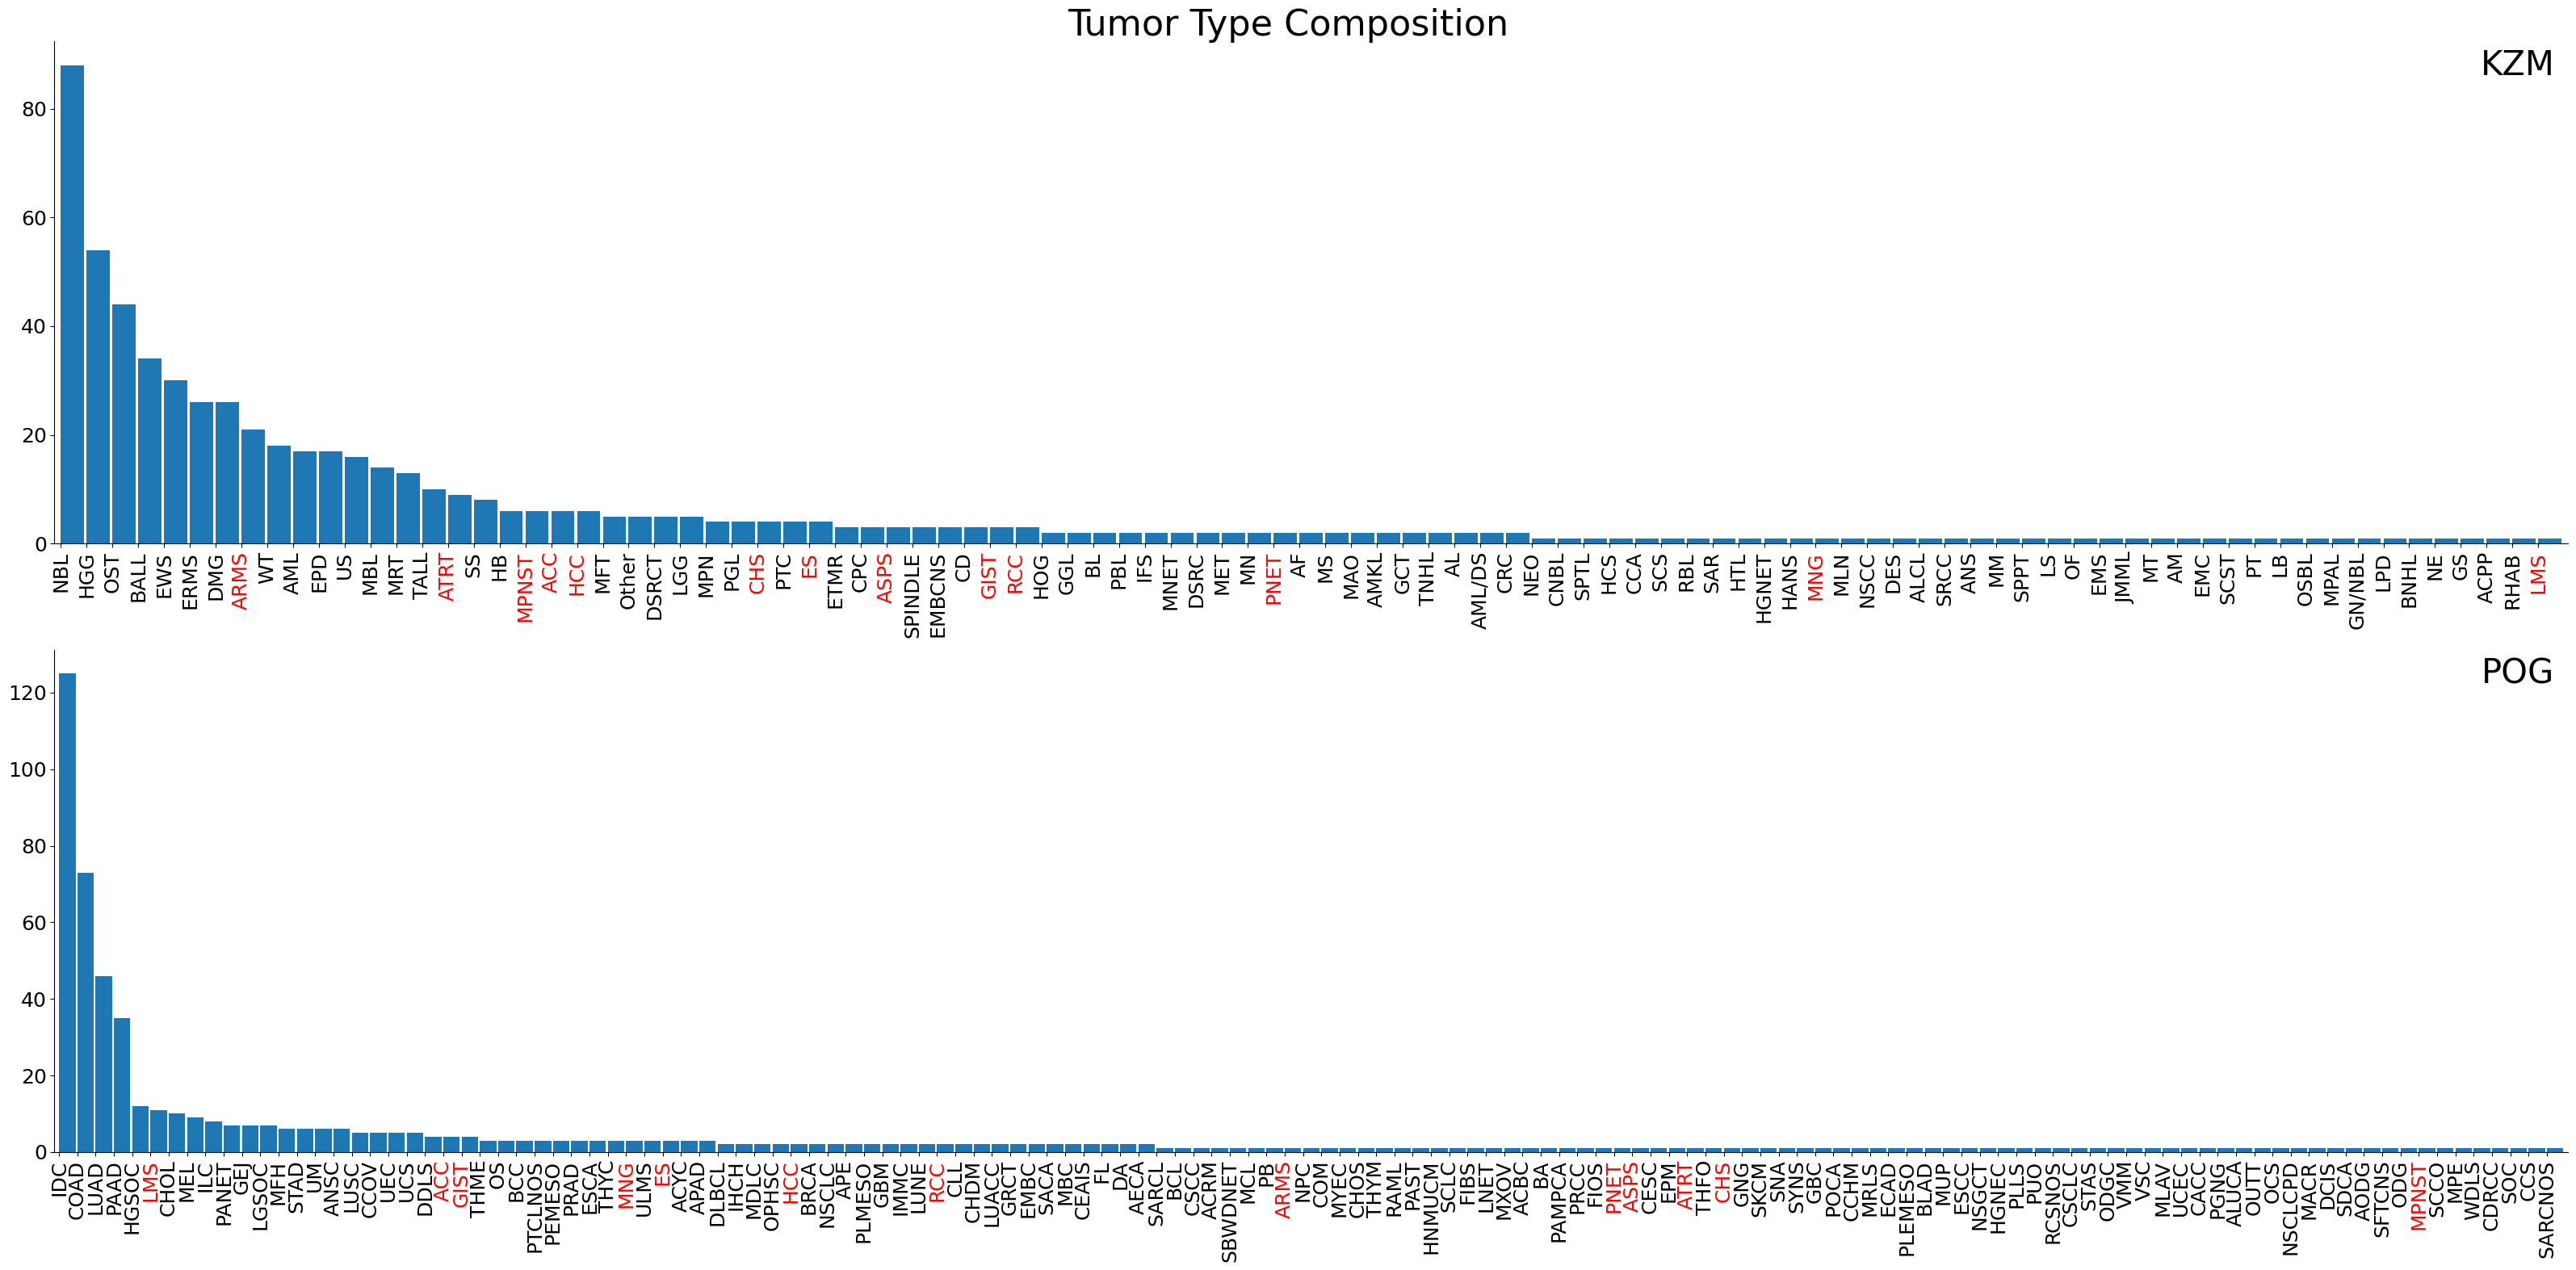

In [10]:
fig, axes = plt.subplots(2,1, figsize=(32, 16))#, gridspec_kw={'height_ratios': [5, 2]})

ax1 = kzm611_md.Type.value_counts().plot.bar(width=0.9, align='edge', ax=axes[0])
ax1.set_xticklabels(kzm_types_sorted.index, fontsize=18)
ax1.set_title('KZM', fontsize=30, y=1.0, x=0.98, pad=-30)
ax1.set_xlabel('')
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.spines[['right', 'top']].set_visible(False)

labels = ax1.get_xticklabels()
for label in labels:
    label.set_color(kzm_colors[label.get_text()])

ax2 = pog570_md.HISTOLOGICAL_TYPE.value_counts().plot.bar(width=0.9, align='edge', ax=axes[1])
ax2.set_xticklabels(pog_types.index, fontsize=18)
ax2.set_title('POG', fontsize=30, y=1, x=0.98, pad=-30)
ax2.set_xlabel('')
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.spines[['right', 'top']].set_visible(False)

labels = ax2.get_xticklabels()
for label in labels:
    label.set_color(pog_colors[label.get_text()])

fig.suptitle('Tumor Type Composition', fontsize=32)

plt.tight_layout()

#plt.savefig(os.path.join(fig_out, 'SuppFig_15a.pdf'), bbox_inches="tight")

In [12]:
## Load therapy data at class and individual drug levels
class_df = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_therapy_classes_NY.txt'), sep='\t', index_col=0)

In [13]:
selected_therapies = ['Platinums', 'Anthracyclines', 'Antimetabolite', 'Camptothecin analogs', 'Chromomycins',
                    'Hydrazines and Triazines', 'Mustard gas derivative', 'Podophyllotoxins', 'Vinca alkaloids',
                    'Alkylating agent, Other', 'Taxanes', 'Topoisomerase II inhibitor']

In [14]:
drug_classes = pd.read_csv(os.path.join(root_dir, 'source_data/Therapy_categories.tsv'), sep='\t', engine='python')
drug_class_dict = dict(zip(drug_classes.Drug, drug_classes.Class))
drug_subclass_dict = dict(zip(drug_classes.Drug, drug_classes.Subclass))

In [15]:
pog_drugs = mu.load_pog_drugs()
pog_drugs.columns = [x.lower().capitalize() for x in pog_drugs.columns]
pog_drugs_class = pog_drugs[[x for x in pog_drugs.columns if x in list(drug_subclass_dict.keys())]].copy()
pog_drugs_class.columns = [drug_subclass_dict[x] for x in pog_drugs_class.columns]
pog_drugs_class = pog_drugs_class.groupby(pog_drugs_class.columns, axis=1).sum()
for col in pog_drugs_class.columns:
    pog_drugs_class[col] = ['Y' if 'Y' in x else 'N' for x in pog_drugs_class[col]]
pog_drugs_class.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Other,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids
POG_37862,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_28132,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N
POG_27723,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_30505,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_34117,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [16]:
from sklearn.metrics.pairwise import pairwise_distances

In [17]:
pog_drugs_class.head()

,"Alkylating agent, Other",Anthracyclines,Antimetabolite,Antitumor antibiotic,Camptothecin analogs,Chromomycins,Hydrazines and Triazines,Monoclonal antibody,Mustard gas derivative,Other,Platinums,Podophyllotoxins,Targeted therapy,Taxanes,Vinca alkaloids
POG_37862,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_28132,N,N,Y,N,N,N,N,N,N,N,Y,N,N,N,N
POG_27723,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_30505,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N
POG_34117,N,N,N,N,N,N,N,N,N,N,N,N,N,N,N


In [18]:
#pog_drugs = mu.load_pog_drugs()
pog_class_hm = pog_drugs_class.copy()
pog_class_hm = pog_class_hm.drop(['Other'], axis=1)
pog_drug_list = pog_class_hm.columns.tolist()
pog_class_hm = pog_class_hm.replace('N', 0)
pog_class_hm = pog_class_hm.replace('Y', 1)

kzm_class_hm = class_df.copy()
kzm_class_hm = kzm_class_hm[~kzm_class_hm.isin(['M']).any(axis=1)]

kzm_class_hm = kzm_class_hm.drop(['Therapy'], axis=1)
kzm_drug_list = kzm_class_hm.columns.tolist()
kzm_class_hm = kzm_class_hm.replace('N', 0)
kzm_class_hm = kzm_class_hm.replace('Y', 1)

pog_class_hm = pd.DataFrame(np.array(pog_class_hm, dtype=int))
kzm_class_hm = pd.DataFrame(np.array(kzm_class_hm, dtype=int))

pog_jacc = 1 - pd.DataFrame(pairwise_distances(pog_class_hm.T.to_numpy(), metric='jaccard'))
pog_jacc.index = pog_jacc.columns = pog_drug_list

kzm_jacc = 1 - pd.DataFrame(pairwise_distances(kzm_class_hm.T.to_numpy(), metric='jaccard'))
kzm_jacc.index = kzm_jacc.columns = kzm_drug_list


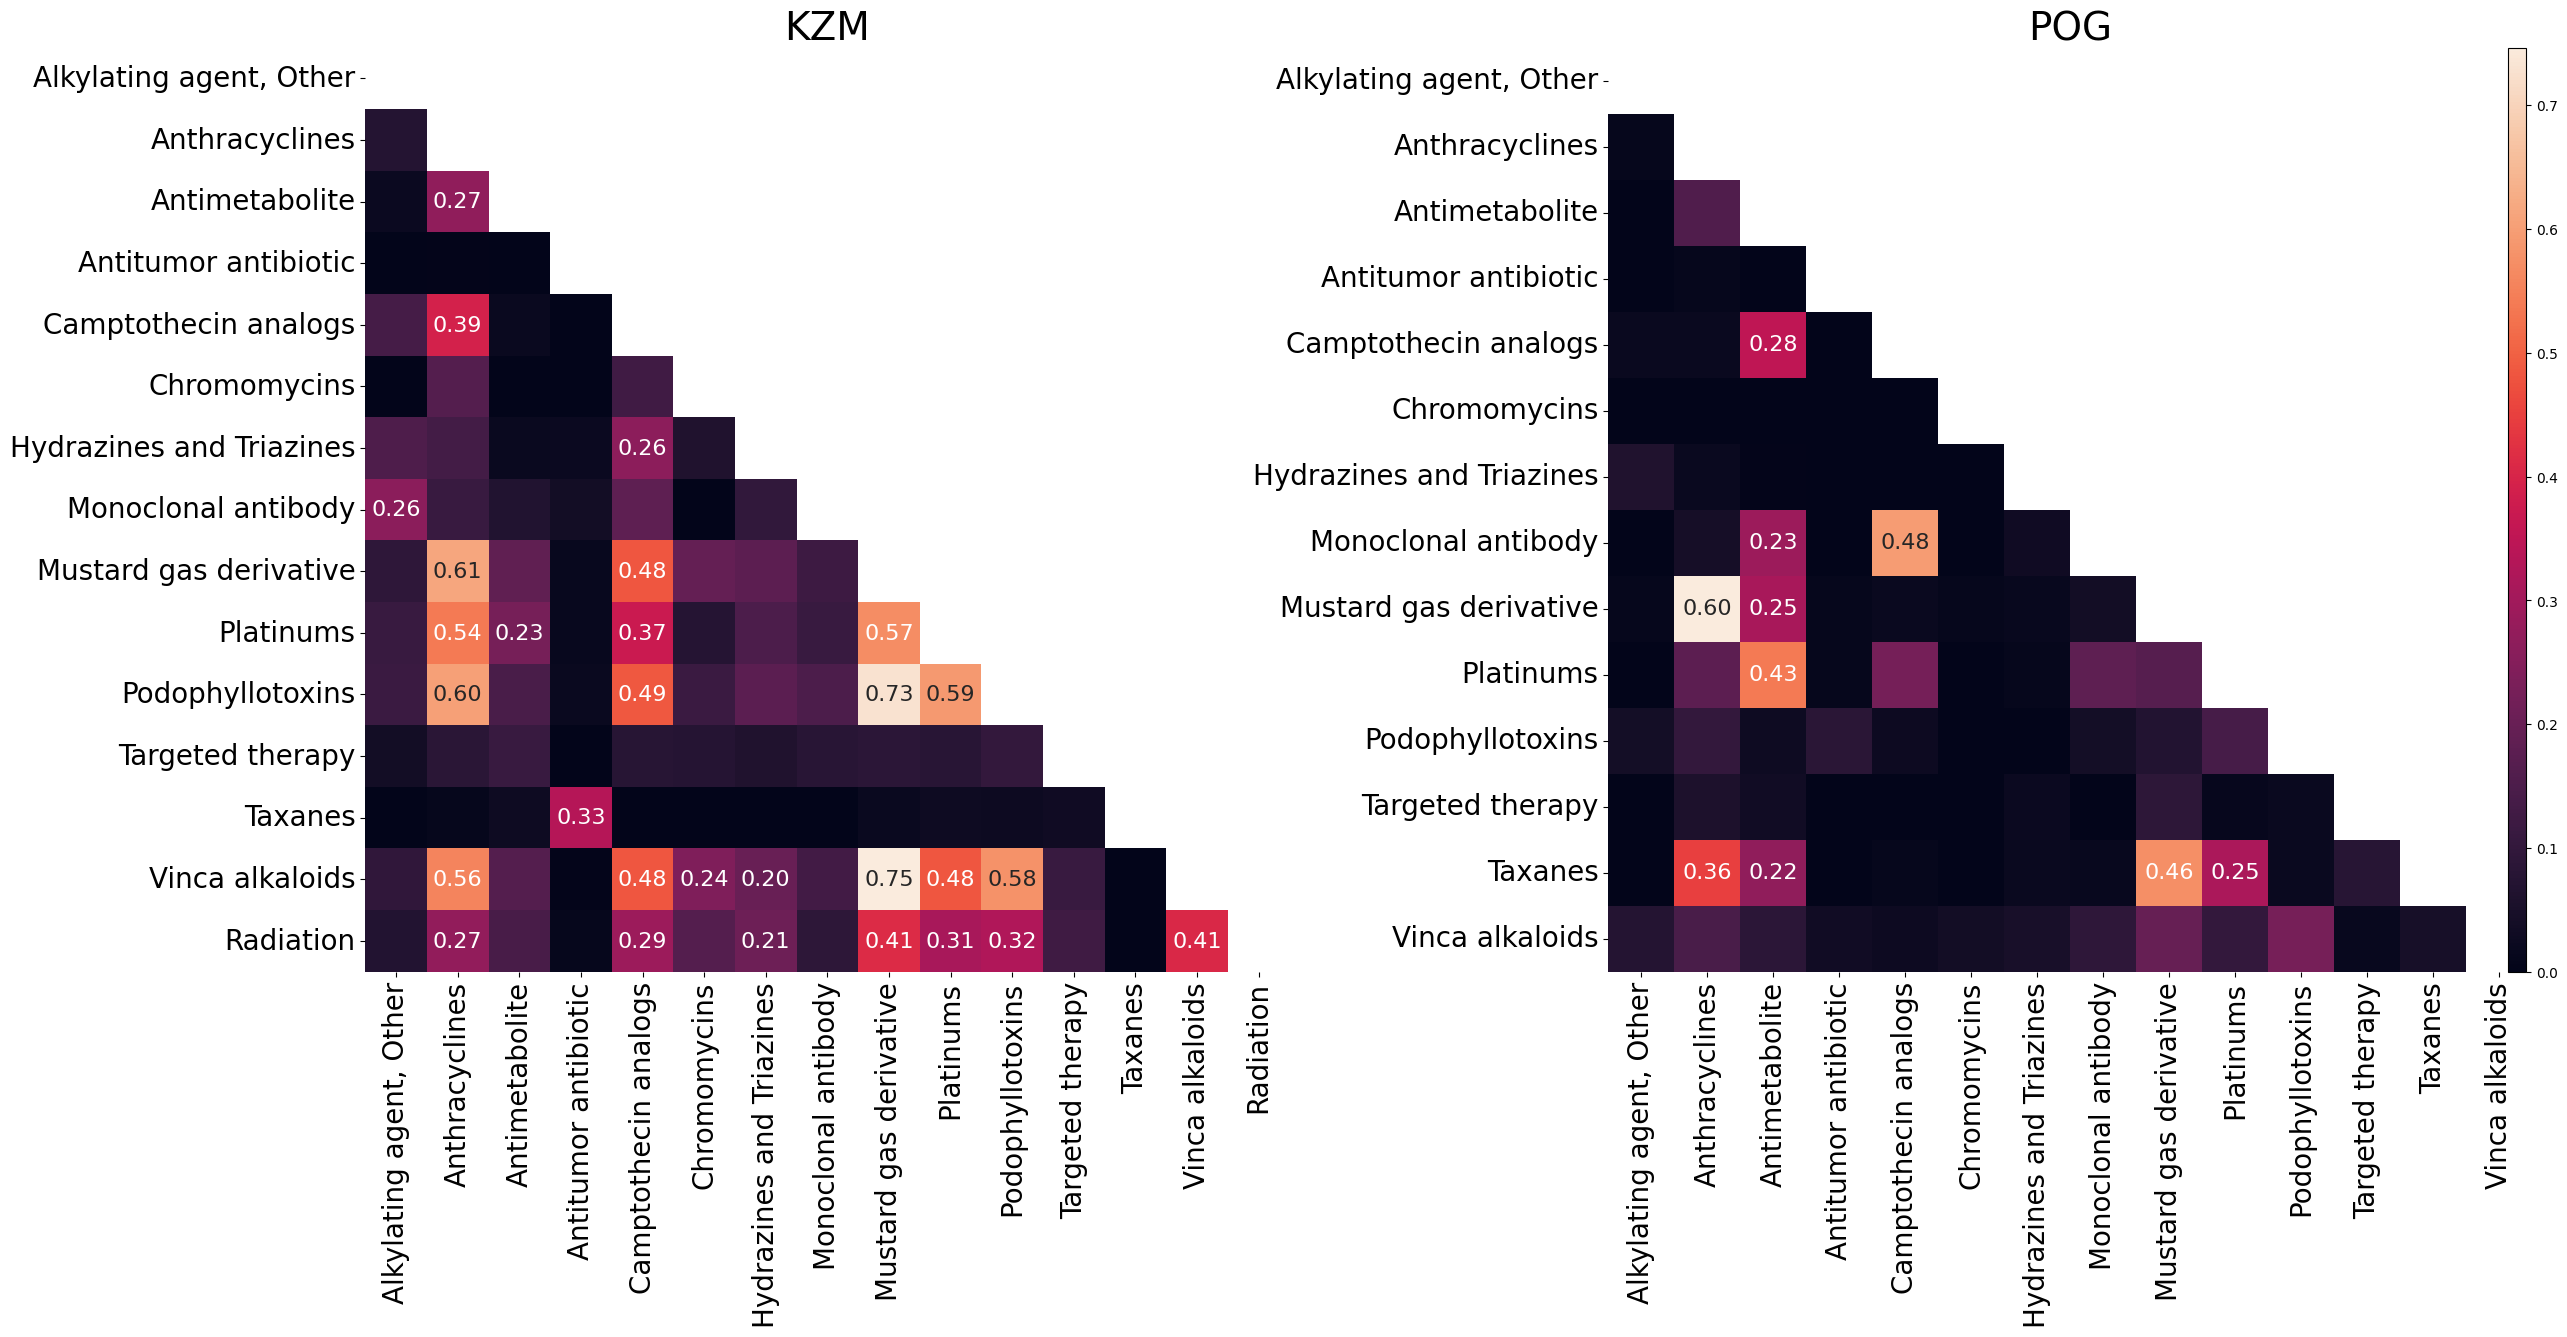

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(32,12))

kzm_mask = np.zeros_like(kzm_jacc)
kzm_mask[np.triu_indices_from(kzm_mask)] = True
pog_mask = np.zeros_like(pog_jacc)
pog_mask[np.triu_indices_from(pog_mask)] = True

ax1 = sns.heatmap(kzm_jacc, mask=kzm_mask, square=True, annot=True, fmt='0.2f', ax=axes[0], cbar=False, annot_kws={"size": 16}, cbar_kws={"orientation": "horizontal"})
ax2 = sns.heatmap(pog_jacc, mask=pog_mask, square=True, annot=True, fmt='0.2f', ax=axes[1], cbar=False, annot_kws={"size": 16}, cbar_kws={"orientation": "horizontal"})

ax1.set_title('KZM', fontsize=28)
ax2.set_title('POG', fontsize=28)

mappable = ax1.get_children()[0]
plt.colorbar(mappable, ax = [axes[0],axes[1]], fraction=0.01, pad=0.01, aspect=50)

ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=20)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=20)
ax2.set_xticklabels(ax2.get_xticklabels(), fontsize=20)
ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=20)

for t in ax1.texts:
    if float(t.get_text())>=0.2:
        t.set_text(t.get_text())
    else:
        t.set_text("")
for t in ax2.texts:
    if float(t.get_text())>=0.2:
        t.set_text(t.get_text())
    else:
        t.set_text("")

plt.subplots_adjust(wspace=0.005)

#plt.savefig(os.path.join(fig_out, 'SuppFig_15b.pdf'), bbox_inches="tight")

In [17]:
pog_novelsigs_r1 = pd.read_csv('/Users/mehdi/Documents/MyRepos/POG/POG_novelSigs_r1.tsv', sep='\t', index_col=0)
pog_novelsigs_r1.head(2)

,SBS288L1,SBS288L2,SBS288L3,SBS288L4,SBS288L5,SBS288H1,SBS288H2,SBS288H3,SBS288H4,SBS288H5
Samples,,,,,,,,,,
POG_11004,0,0,0,0,0,0,3332,9246,0,0
POG_11307,0,1305,0,0,0,0,564,2279,0,0


In [28]:
pog_novelsigs_r2 = pd.read_csv('/Users/mehdi/Documents/MyRepos/POG/POG_novelSigs_r2.tsv', sep='\t', index_col=0)
pog_novelsigs_r2.head(2)

,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,SBS7d,...,SBS288L1,SBS288L2,SBS288L3,SBS288L4,SBS288L5,SBS288H1,SBS288H2,SBS288H3,SBS288H4,SBS288H5
Samples,,,,,,,,,,,,,,,,,,,,,
POG_11004,2139,0,0,0,1305,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
POG_11307,423,0,0,0,1706,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
pog_novelDBS_r2 = pd.read_csv('/Users/mehdi/Documents/MyRepos/POG/POG_novelDBS_r2.tsv', sep='\t', index_col=0)
pog_novelDBS_r2.head(2)

,DBS1,DBS2,DBS3,DBS4,DBS5,DBS6,DBS7,DBS8,DBS9,DBS10,...,DBS15,DBS16,DBS17,DBS18,DBS19,DBS20,DBS78L1,DBS78H1,DBS78H2,DBS78H3
Samples,,,,,,,,,,,,,,,,,,,,,
POG_14498,0,21,0,0,0,25,0,0,0,0,...,0,0,0,0,0,0,0,0,50,0
POG_15844,0,30,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
pog_drugs_class.loc[pog_novelsigs_r1[pog_novelsigs_r1.SBS288L5>99].index.tolist()].Platinums.value_counts()

Platinums
Y    54
N    19
Name: count, dtype: int64

In [29]:
pog_drugs_class.loc[pog_novelsigs_r2[pog_novelsigs_r2.SBS288L5>99].index.tolist()].Platinums.value_counts()

Platinums
Y    16
Name: count, dtype: int64

In [26]:
pog_drugs_class.loc[pog_novelDBS_r2[pog_novelDBS_r2.DBS78H2>24].index.tolist()].Platinums.value_counts()

Platinums
Y    12
Name: count, dtype: int64